# Position Movement

In [1]:
import pandas as pd

# read section times
df = pd.read_parquet('../cleandata/section results/sectionresults_2017-04-09_3678_Toyota Grand Prix of Long Beach.pq')
df.sample(3).T

# read box score
box = pd.read_csv('Long Beach 2017 Box.csv')
box['Car'] = box.Car.astype(str)
box['Tot'] = box['Elapsed'].apply(lambda x: 3600*float(x.split(':')[0])
                                  +60*float(x.split(':')[1])
                                  +float(x.split(':')[2]))

dfj = df.merge(box[['Car','Laps']],on='Car')
dfj = dfj.loc[dfj.Lap <= dfj.Laps].copy()

agg = dfj.loc[dfj.Section == 'Lap'].groupby(['Driver','Car'])['Time'].agg(['sum','count']).reset_index()
agg['Elapsed'] = agg['sum'].apply(lambda x: f'{int(x//3600)}:{(int(x%3600)//60)}:{x%60:.3f}')
agg.sort_values(['count','sum'], ascending = [False,True])

j=box.merge(agg, on='Car',suffixes = ['_box','_sec'])
j.sample(3).T

j['Gap'] =  j.Tot - j['sum']
j[['Name','Car','Start','Elapsed_sec','Elapsed_box','Laps','count','Gap']].sort_values('Gap')

,Name,Car,Start,Elapsed_sec,Elapsed_box,Laps,count,Gap
3,Scott Dixon,9,2,1:50:31.765,01:50:31.7650,85,85,0.0000
0,James Hinchcliffe,5,4,1:50:28.826,01:50:28.9818,85,85,0.1560
16,Ryan Hunter-Reay,28,3,1:41:38.381,01:41:38.5661,79,79,0.1846
8,Helio Castroneves,3,1,1:50:38.065,01:50:38.3221,85,85,0.2570
18,Alexander Rossi,98,5,1:15:43.013,01:15:43.3798,62,62,0.3670
9,Graham Rahal,15,6,1:50:46.317,01:50:46.8450,85,85,0.5280
2,Josef Newgarden,2,8,1:50:30.691,01:50:31.2978,85,85,0.6066
12,Will Power,12,9,1:50:47.279,01:50:48.0027,84,84,0.7237
20,Charlie Kimball,83,7,0:2:24.885,00:02:25.6236,1,1,0.7385
14,Tony Kanaan,10,11,1:50:48.023,01:50:49.0126,84,84,0.9893


In [2]:
l0 = j[['Car','Driver','Gap']].rename(columns  = {'Gap':'LapTime'})
l0['Lap']=0
l0['Flag'] = 'Green'

dftime = df.loc[df.Section == 'Lap',['Car','Driver','Time','Lap','Flag']].rename(columns = {'Time':'LapTime'})
times = pd.concat([l0,dftime]).sort_values(['Lap','Car']).reset_index(drop=True)

# get time in seconds since start
times['RaceTime'] = times.groupby('Car')['LapTime'].cumsum()

# gap to next driver
times = times.sort_values('RaceTime').reset_index(drop=True)
times['Gap'] = times.RaceTime - times.RaceTime.shift(1)

times['LapStarted'] = times['Lap']+1
times.rename(columns = {'Lap':'LapCompleted'},inplace=True)

In [3]:
# look at pit stops
inlaps = (df.loc[df.Section == 'SF to PI',['Car','Lap']]
          .rename(columns={'Lap':'LapStarted'}).copy())
inlaps['InLap'] = 1
outlaps = (df.loc[(df.Lap > 1) & (df.Section=='PO to SF'), ['Car','Lap']]
           .rename(columns={'Lap':'LapStarted'}).copy())
outlaps['OutLap'] = 1
ps = (times
      .merge(inlaps, on=['Car','LapStarted'],how='left')
      .merge(outlaps, on=['Car','LapStarted'],how='left')
     )

# define last pit lap
ps['LastPitLap'] = ps.loc[ps.OutLap==1,'LapStarted']
ps.loc[ps.LapStarted == 1,'LastPitLap'] = 1
ps['LastPitLap'] = ps.groupby('Car').LastPitLap.ffill()
ps['LapsSincePit'] = (ps.LapStarted - ps.LastPitLap).astype(int)

ps['InLap'] = ps.InLap.fillna(0).astype(int)
pd.set_option('display.max_rows',100)
ps.loc[ps.Car == '12'].head(20)

,Car,Driver,LapTime,LapCompleted,Flag,RaceTime,Gap,LapStarted,InLap,OutLap,LastPitLap,LapsSincePit
7,12,"Power, Will",0.7237,0,Green,0.7237,0.1171,1,0,NaN,1.0,0
41,12,"Power, Will",162.5258,1,Green,163.2495,11.9438,2,1,NaN,1.0,1
59,12,"Power, Will",95.1213,2,Yellow,258.3708,14.9547,3,0,1.0,3.0,0
79,12,"Power, Will",112.7457,3,Yellow,371.1165,9.2762,4,0,NaN,3.0,1
99,12,"Power, Will",106.5872,4,Yellow,477.7037,0.5618,5,0,NaN,3.0,2
119,12,"Power, Will",72.9454,5,Green,550.6491,0.2980,6,0,NaN,3.0,3
139,12,"Power, Will",71.5951,6,Green,622.2442,0.6523,7,0,NaN,3.0,4
159,12,"Power, Will",70.6307,7,Green,692.8749,0.6211,8,0,NaN,3.0,5
179,12,"Power, Will",70.4197,8,Green,763.2946,0.3826,9,0,NaN,3.0,6
199,12,"Power, Will",71.2700,9,Green,834.5646,0.7796,10,0,NaN,3.0,7


In [90]:
rk = ps[['LapStarted']].drop_duplicates().merge(ps[['Car']].drop_duplicates(),how='cross')
rk = rk.merge(ps,on=['Car','LapStarted'],how='left')
rk['P'] = rk.groupby('LapStarted')['RaceTime'].rank(ascending=True)
rk['Retired'] = rk.P.isna().astype(int)

rk['RT2'] = rk.sort_values(['Car','LapStarted'])['RaceTime'].ffill()
rk.loc[rk.P.isna(),'P'] = (rk.Car.nunique()+1) - (rk.loc[rk.P.isna()].groupby('LapStarted')['RT2'].rank())
rk.drop(columns = 'RT2',inplace=True)

In [93]:
stints = rk[['LapStarted','Car','OutLap','InLap','P','LastPitLap','LapsSincePit','Retired']].copy()
stints['OutLap'] = stints.OutLap.fillna(0).astype(int)
stints['InLap'] = stints.InLap.fillna(0).astype(int)
stints['Stint'] = (stints.groupby('Car')['OutLap'].cumsum()) +1
stints['nStints'] = stints.groupby('Car')['Stint'].transform('max')
stints['rStint'] = stints.Stint-stints.nStints-1
stints['OutLapCompleted'] = (stints.sort_values(['Car','LapStarted'])['OutLap']
                             .shift(1).fillna(0).astype(int)
                            )

In [101]:
stints['Stint+1'] = stints.Stint+1
cols = ['LapStarted','Car','P','InLap','OutLapCompleted','Stint','Stint+1','Retired',
       'LapsSincePit']
sm = stints[cols].merge(stints[cols],
                        on=['LapStarted'],how='inner',suffixes=('1','2'))
smf = sm.loc[(sm.InLap1+sm.InLap2+sm.OutLapCompleted1+sm.OutLapCompleted2 > 0)].copy()
# dataframe of all pit lane passes
pp = (smf.loc[(smf.P1 > smf.P2) & (smf.InLap1+smf.InLap2 > 0)]
       .merge(smf.loc[(smf.P1 < smf.P2) 
                      & (smf.OutLapCompleted1+smf.OutLapCompleted2 > 0)
                      & (smf.Retired1+smf.Retired2 == 0)
                     ],
              left_on = ['Stint+11','Stint+12','Car1','Car2'],
              right_on = ['Stint1','Stint2','Car1','Car2'],
              suffixes = ('_Pre','_Post'), how='inner')
      )


In [106]:
pp['LapDiff'] = pp.LapStarted_Post - pp.LapStarted_Pre -2
pp['LSPDiff'] = abs(pp.LapsSincePit2_Pre - pp.LapsSincePit1_Pre)
pp.groupby('LapDiff')['LSPDiff'].agg(['min','max','mean','count'])


,min,max,mean,count
LapDiff,,,,
0,0.0,4.0,1.083333,36
1,0.0,8.0,1.857143,7
2,0.0,4.0,1.142857,7
3,0.0,0.0,0.000000,1
4,1.0,1.0,1.000000,1
5,0.0,0.0,0.000000,1
8,0.0,0.0,0.000000,3
9,0.0,0.0,0.000000,1
12,0.0,16.0,5.000000,6


In [110]:
pp.loc[pp.Car1.isin(['20','19'])].T

,11,12,13,14,15,16,17,18,19,20,53,57,77,94
LapStarted_Pre,2,2,2,2,2,2,2,2,2,2,14,15,36,60
Car1,20,20,20,20,20,20,20,20,20,20,19,19,19,19
P1_Pre,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,8.0,7.0,8.0,10.0
InLap1_Pre,1,1,1,1,1,1,1,1,1,1,0,1,0,0
OutLapCompleted1_Pre,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Stint1_Pre,1,1,1,1,1,1,1,1,1,1,1,1,2,3
Stint+11_Pre,2,2,2,2,2,2,2,2,2,2,2,2,3,4
Retired1_Pre,0,0,0,0,0,0,0,0,0,0,0,0,0,0
LapsSincePit1_Pre,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,13.0,14.0,20.0,22.0
Car2,9,3,2,10,27,18,19,14,21,26,3,15,14,10


In [9]:
# flags
flags = (df
         .groupby(['Car','Lap'])
         ['Flag']
         .apply(list)
         .rename('SectionFlags')
         .reset_index()
        )
flags['Flag'] = flags['SectionFlags'].apply(lambda x: 'Yellow Thrown' if ('Yellow' in x and 'Green' in x)
                                            else 'Red' if 'Red' in x 
                                            else 'Yellow' if 'Yellow' in x 
                                            else 'Green')

In [10]:
# assemble training df
ot = (times[['Car','Driver','LapStarted','RaceTime','Gap']]
      .merge(ps[['Car','LapStarted','InLap','LapsSincePit']],
             on=['Car','LapStarted'], how='left')
      .merge(flags[['Car','Lap','Flag']], how='inner',
             left_on=['Car','LapStarted'], right_on=['Car','Lap'])
     )
ot.iloc[0:20]

,Car,Driver,LapStarted,RaceTime,Gap,InLap,LapsSincePit,Lap,Flag
0,9,"Dixon, Scott",1,0.0000,NaN,0,0,1,Yellow Thrown
1,5,"Hinchcliffe, James",1,0.1560,0.1560,0,0,1,Yellow Thrown
2,28,"Hunter-Reay, Ryan",1,0.1846,0.0286,0,0,1,Yellow Thrown
3,3,"Castroneves, Helio",1,0.2570,0.0724,0,0,1,Yellow Thrown
4,98,"Rossi, Alexander",1,0.3670,0.1100,0,0,1,Yellow Thrown
5,15,"Rahal, Graham",1,0.5280,0.1610,0,0,1,Yellow Thrown
6,2,"Newgarden, Josef",1,0.6066,0.0786,0,0,1,Yellow Thrown
7,12,"Power, Will",1,0.7237,0.1171,0,0,1,Yellow Thrown
8,83,"Kimball, Charlie",1,0.7385,0.0148,1,0,1,Yellow Thrown
9,10,"Kanaan, Tony",1,0.9893,0.2508,0,0,1,Yellow Thrown


In [11]:
for i in ot.loc[1:].index:
    lap = ot.loc[i,'LapStarted']
    car = ot.loc[i,'Car']
    nextidx = ot.loc[(ot.Car == car) & (ot.LapStarted == lap+1)].index
    if len(nextidx) == 0:
        ot.loc[i,'Retired'] = 1
    else:
        carinfront = ot.loc[i-1,'Car']
        ot.loc[i,'Overtake'] = int(carinfront not in ot.loc[i:nextidx[0],'Car'].values)
ot['Retired'] = ot.Retired.fillna(0).astype(int)
ot.head(50)     

,Car,Driver,LapStarted,RaceTime,Gap,InLap,LapsSincePit,Lap,Flag,Overtake,Retired
0,9,"Dixon, Scott",1,0.0000,NaN,0,0,1,Yellow Thrown,NaN,0
1,5,"Hinchcliffe, James",1,0.1560,0.1560,0,0,1,Yellow Thrown,0.0,0
2,28,"Hunter-Reay, Ryan",1,0.1846,0.0286,0,0,1,Yellow Thrown,0.0,0
3,3,"Castroneves, Helio",1,0.2570,0.0724,0,0,1,Yellow Thrown,0.0,0
4,98,"Rossi, Alexander",1,0.3670,0.1100,0,0,1,Yellow Thrown,1.0,0
5,15,"Rahal, Graham",1,0.5280,0.1610,0,0,1,Yellow Thrown,1.0,0
6,2,"Newgarden, Josef",1,0.6066,0.0786,0,0,1,Yellow Thrown,0.0,0
7,12,"Power, Will",1,0.7237,0.1171,0,0,1,Yellow Thrown,0.0,0
8,83,"Kimball, Charlie",1,0.7385,0.0148,1,0,1,Yellow Thrown,NaN,1
9,10,"Kanaan, Tony",1,0.9893,0.2508,0,0,1,Yellow Thrown,1.0,0


In [23]:
ot['Index-1'] = ot.index-1
ot2 = (ot[['Car','Driver','LapStarted','Gap','InLap','LapsSincePit','Flag','Overtake','Retired','Index-1']]
       .join(ot[['LapStarted','Gap','LapsSincePit','InLap','Retired']],
              on='Index-1',how='left',rsuffix='_CIF')
      )
ot2.drop(columns = ['Index-1'],inplace=True)
ot2.sample(10)

,Car,Driver,LapStarted,Gap,InLap,LapsSincePit,Flag,Overtake,Retired,LapStarted_CIF,Gap_CIF,LapsSincePit_CIF,InLap_CIF,Retired_CIF
897,20,"Pigot, Spencer",47,1.1900,0,17,Green,0.0,0,47.0,2.1387,17.0,0.0,0.0
1600,14,"Munoz, Carlos",86,1.1442,0,25,Green,NaN,1,86.0,2.4017,23.0,0.0,1.0
780,18,"Bourdais, Sebastien",41,11.3897,0,10,Green,0.0,0,41.0,3.6539,12.0,0.0,0.0
177,26,"Sato, Takuma",9,0.4409,0,6,Green,1.0,0,9.0,1.5320,8.0,0.0,0.0
1084,28,"Hunter-Reay, Ryan",57,4.0334,0,0,Green,0.0,0,57.0,1.2423,23.0,0.0,0.0
17,7,"Aleshin, Mikhail",1,0.1368,0,0,Yellow Thrown,0.0,0,1.0,0.2990,0.0,0.0,0.0
1473,14,"Munoz, Carlos",78,0.9225,0,17,Green,0.0,0,78.0,0.9793,15.0,0.0,0.0
1166,1,"Pagenaud, Simon",61,4.3274,0,2,Green,1.0,0,61.0,5.0549,0.0,0.0,0.0
1259,19,"Jones, Ed (R)",66,0.1392,0,3,Yellow,1.0,0,66.0,0.4798,5.0,0.0,0.0
252,26,"Sato, Takuma",13,2.7706,0,0,Green,0.0,0,13.0,6.5859,10.0,0.0,0.0


In [36]:
ot2.loc[ot2.Flag.isin(['Green','Yellow Thrown']) & (ot2.Overtake == 1) & (ot2.InLap_CIF == 0),'OvertakeOnTrack'] = 1
ot2['OvertakeOnTrack'] = ot2.OvertakeOnTrack.fillna(0)
ot2.loc[ot2.OvertakeOnTrack == 1]

,Car,Driver,LapStarted,Gap,InLap,LapsSincePit,Flag,Overtake,Retired,LapStarted_CIF,Gap_CIF,LapsSincePit_CIF,InLap_CIF,Retired_CIF,Backmarker,PitGap,OvertakeOnTrack
4,98,"Rossi, Alexander",1,0.1100,0,0,Yellow Thrown,1.0,0,1.0,0.0724,0.0,0.0,0.0,0,0.0,1.0
5,15,"Rahal, Graham",1,0.1610,0,0,Yellow Thrown,1.0,0,1.0,0.1100,0.0,0.0,0.0,0,0.0,1.0
18,8,"Chilton, Max",1,0.5471,0,0,Yellow Thrown,1.0,0,1.0,0.1368,0.0,0.0,0.0,0,0.0,1.0
73,8,"Chilton, Max",4,0.2152,0,3,Yellow Thrown,1.0,0,4.0,3.4085,3.0,0.0,0.0,0,0.0,1.0
95,7,"Aleshin, Mikhail",5,0.1431,0,4,Green,1.0,0,5.0,0.9103,2.0,0.0,0.0,0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,12,"Power, Will",82,0.9511,0,1,Green,1.0,0,83.0,0.1913,22.0,0.0,0.0,0,-21.0,1.0
1575,8,"Chilton, Max",83,0.3580,0,2,Green,1.0,0,84.0,0.2629,23.0,0.0,0.0,0,-21.0,1.0
1588,15,"Rahal, Graham",85,0.3806,0,5,Green,1.0,0,85.0,3.4756,25.0,0.0,1.0,0,-20.0,1.0
1592,4,"Daly, Conor",84,0.3403,0,3,Green,1.0,0,85.0,0.1559,24.0,0.0,1.0,0,-21.0,1.0


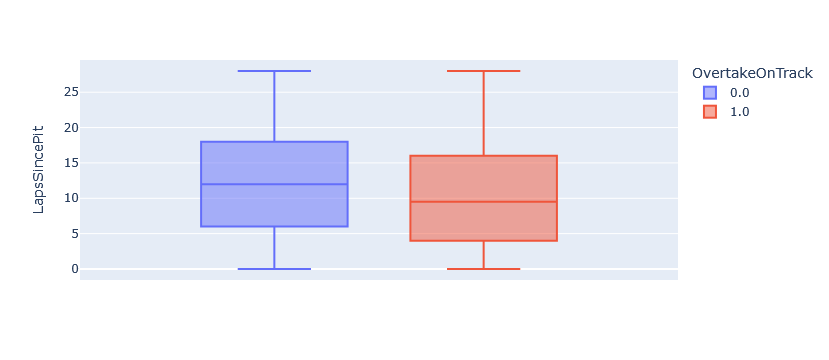

In [40]:
import plotly.express as px
px.box(ot2.loc[ot2.Flag == 'Green'],y='LapsSincePit',color='OvertakeOnTrack')

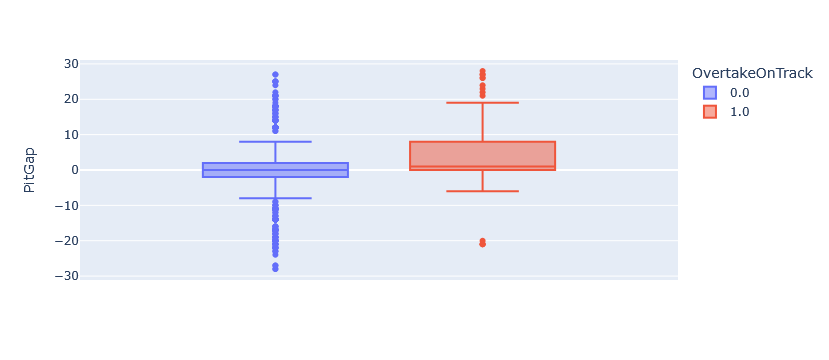

In [41]:
px.box(ot2.loc[ot2.Flag == 'Green'],y='PitGap',color='OvertakeOnTrack')

In [33]:
ot2['Backmarker'] = (ot2.LapStarted > ot2.LapStarted_CIF).astype(int)
ot2['PitGap'] = ot2.LapsSincePit - ot2.LapsSincePit_CIF

In [42]:
ot2.groupby(['Overtake','OvertakeOnTrack'])[['LapsSincePit','PitGap']].agg(['mean','median','count'])

LapsSincePit                 PitGap             
                                 mean median count      mean median count
Overtake OvertakeOnTrack                                                 
0.0      0.0                11.081518   10.0  1423 -0.129304    0.0  1423
1.0      0.0                10.372881    8.0    59 -3.966102   -1.0    59
         1.0                10.096154    8.5   104  3.923077    1.0   104

## Overtake Matrix


In [45]:
ot.groupby('Car').agg({'LapStarted':'max','RaceTime':'max'}).sort_values(['LapStarted','RaceTime'],ascending = False).reset_index()

,Car,LapStarted,RaceTime
0,15,86,6646.8450
1,3,86,6638.3221
2,20,86,6638.0388
3,14,86,6635.9211
4,19,86,6634.7769
5,1,86,6632.3752
6,9,86,6631.7650
7,2,86,6631.2978
8,18,86,6630.4758
9,5,86,6628.9818
